# Credit Risk Resampling Techniques

In [72]:
"""
Risk Classification
~~~~~~~~~~~~~~~~

This module provides classification for applied loans as Approved or deny due to credit risk.

This module accepts comma separated .csv file. 

It provides a data models to use for risk classification - 

- Use Supervised Learning logistic regression classification model

- Use different options and parameters to come up with balanced accuracy score.

- 

"""

import warnings
warnings.filterwarnings('ignore')

In [73]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import plotly.express as px
from pandas_profiling import ProfileReport
import hvplot.pandas
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from imblearn.metrics import make_index_balanced_accuracy
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.utils import compute_class_weight
import seaborn as sns


In [74]:
#Initialize a dictionary to store the result of balanced_accuracy_score, geometric_mean and recall_score for each model validated.
Dict_Balanced = {}
Dict_gm = {}
Dict_r = {}

# Read the CSV into DataFrame

In [75]:
# Load the data
file_path = Path('./Data/lending_data.csv') 
lending_data_df = pd.read_csv(file_path)


*Data Profiling*

In [76]:
display(lending_data_df.head())
display(lending_data_df.tail())

loan_size  interest_rate homeowner  borrower_income  debt_to_income  \
0    10700.0          7.672       own            52800        0.431818   
1     8400.0          6.692       own            43600        0.311927   
2     9000.0          6.963      rent            46100        0.349241   
3    10700.0          7.664       own            52700        0.430740   
4    10800.0          7.698  mortgage            53000        0.433962   

   num_of_accounts  derogatory_marks  total_debt loan_status  
0                5                 1       22800    low_risk  
1                3                 0       13600    low_risk  
2                3                 0       16100    low_risk  
3                5                 1       22700    low_risk  
4                5                 1       23000    low_risk

loan_size  interest_rate homeowner  borrower_income  debt_to_income  \
77531    19100.0         11.261       own            86600        0.653580   
77532    17700.0         10.662  mortgage            80900        0.629172   
77533    17600.0         10.595      rent            80300        0.626401   
77534    16300.0         10.068  mortgage            75300        0.601594   
77535    15600.0          9.742  mortgage            72300        0.585062   

       num_of_accounts  derogatory_marks  total_debt loan_status  
77531               12                 2       56600   high_risk  
77532               11                 2       50900   high_risk  
77533               11                 2       50300   high_risk  
77534               10                 2       45300   high_risk  
77535                9                 2       42300   high_risk

In [77]:
#Check for nulls or nan
lending_data_df.isnull().sum()

loan_size           0
interest_rate       0
homeowner           0
borrower_income     0
debt_to_income      0
num_of_accounts     0
derogatory_marks    0
total_debt          0
loan_status         0
dtype: int64

In [78]:
#Data Types
lending_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_size         77536 non-null  float64
 1   interest_rate     77536 non-null  float64
 2   homeowner         77536 non-null  object 
 3   borrower_income   77536 non-null  int64  
 4   debt_to_income    77536 non-null  float64
 5   num_of_accounts   77536 non-null  int64  
 6   derogatory_marks  77536 non-null  int64  
 7   total_debt        77536 non-null  int64  
 8   loan_status       77536 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 5.3+ MB


In [79]:
profile = ProfileReport(lending_data_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Above profile shows following breakdown for loan_status field values (our Target) -
low_risk	75036 
high_risk	 2500

It clearly shows an imbalanced data.
For Imbalanced data, we should be using balanced_accuracy to validate the model. We should also try different options provided by logistic regression module of sklearn and sampling.

In [80]:
#If you observe, there is one field homeowner which only has 3 distinct values and does
#not show any correlation with anyother field.
# #Converting Categorical columns into one hot encoding
# We will first convert our target to a 1 or 0 values.
lending_data_df["loan_status"]=lending_data_df["loan_status"].apply(lambda x: 1 if x=="low_risk" else 0)

categorical_columns = lending_data_df.select_dtypes(["object"]).columns
#Create dummy variables
#tempdf=pd.get_dummies(lending_data_df[cols],drop_first=True)

for column in categorical_columns:
    tempdf = pd.get_dummies(lending_data_df[column], prefix=column)
    lending_data_df = pd.merge(
        left=lending_data_df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    lending_data_df = lending_data_df.drop(columns=column)
print(lending_data_df)

       loan_size  interest_rate  borrower_income  debt_to_income  \
0        10700.0          7.672            52800        0.431818   
1         8400.0          6.692            43600        0.311927   
2         9000.0          6.963            46100        0.349241   
3        10700.0          7.664            52700        0.430740   
4        10800.0          7.698            53000        0.433962   
...          ...            ...              ...             ...   
77531    19100.0         11.261            86600        0.653580   
77532    17700.0         10.662            80900        0.629172   
77533    17600.0         10.595            80300        0.626401   
77534    16300.0         10.068            75300        0.601594   
77535    15600.0          9.742            72300        0.585062   

       num_of_accounts  derogatory_marks  total_debt  loan_status  \
0                    5                 1       22800            1   
1                    3                 0     

In [81]:
lending_data_df.columns

Index(['loan_size', 'interest_rate', 'borrower_income', 'debt_to_income',
       'num_of_accounts', 'derogatory_marks', 'total_debt', 'loan_status',
       'homeowner_mortgage', 'homeowner_own', 'homeowner_rent'],
      dtype='object')

In [82]:
profile1 = ProfileReport(lending_data_df, title="Pandas Profiling Report")
profile1

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Split the Data into Training and Testing

In [83]:
# Create our features
X = lending_data_df.drop(columns="loan_status")


# Create our target
y = lending_data_df["loan_status"].copy()

In [84]:
X.describe()

loan_size  interest_rate  borrower_income  debt_to_income  \
count  77536.000000   77536.000000     77536.000000    77536.000000   
mean    9805.562577       7.292333     49221.949804        0.377318   
std     2093.223153       0.889495      8371.635077        0.081519   
min     5000.000000       5.250000     30000.000000        0.000000   
25%     8700.000000       6.825000     44800.000000        0.330357   
50%     9500.000000       7.172000     48100.000000        0.376299   
75%    10400.000000       7.528000     51400.000000        0.416342   
max    23800.000000      13.235000    105200.000000        0.714829   

       num_of_accounts  derogatory_marks    total_debt  homeowner_mortgage  \
count     77536.000000      77536.000000  77536.000000        77536.000000   
mean          3.826610          0.392308  19221.949804            0.497472   
std           1.904426          0.582086   8371.635077            0.499997   
min           0.000000          0.000000      0.000000            0.000000   
25%           3.000000          0.000000  14800.000000            0.000000   
50%           4.000000          0.000000  18100.000000            0.000000   
75%           4.000000          1.000000  21400.000000            1.000000   
max          16.000000          3.000000  75200.000000            1.000000   

       homeowner_own  homeowner_rent  
count   77536.000000    77536.000000  
mean        0.398911        0.103616  
std         0.489678        0.304764  
min         0.000000        0.000000  
25%         0.000000        0.000000  
50%         0.000000        0.000000  
75%         1.000000        0.000000  
max         1.000000        1.000000

In [85]:
# 1 = low_risk and 0 = high_risk
y.value_counts()

1    75036
0     2500
Name: loan_status, dtype: int64

Create X_train, X_test, y_train, y_test using 80% - 20% split size.
We can use the train_test_split function from sklearn:

with the *stratify* argument based on Target categories. So that both the training and test datasets will have similar portions of Target as the complete dataset. This is important for imbalanced data.
with *random_state* set as an integer, so that we’ll get the same result each time running.

In [86]:
X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y, 
                                                   random_state=1, 
                                                   stratify=y,test_size=0.2)
X_train.shape

(62028, 10)

In [87]:
#check the Target balance in training and test splits
# 1 = low_risk and 0 = high_risk
display(y_train.value_counts())

display(y_test.value_counts())

1    60028
0     2000
Name: loan_status, dtype: int64

1    15008
0      500
Name: loan_status, dtype: int64

In [88]:
#Visualize the same
y_train.value_counts().hvplot(kind='bar') + y_test.value_counts().hvplot(kind='bar')

:Layout
   .Bars.Loan_status.I  :Bars   [index]   (loan_status)
   .Bars.Loan_status.II :Bars   [index]   (loan_status)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_test`).

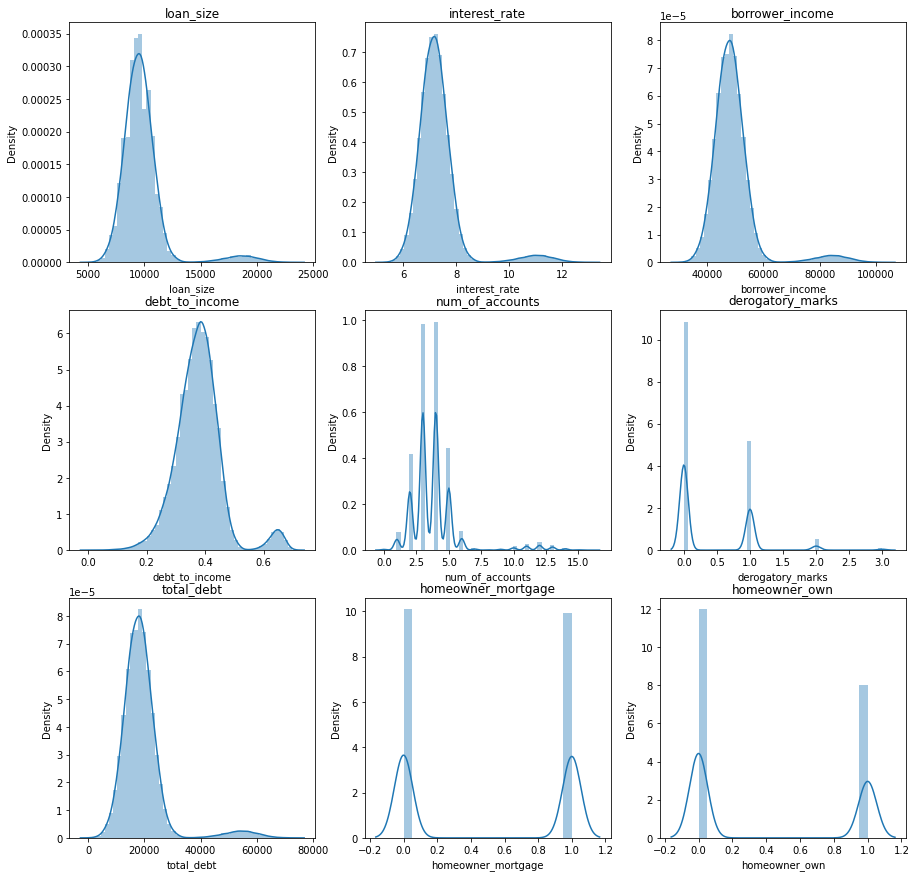

In [89]:
#Let's check the distribution of each of the features.
fig, axes = plt.subplots(nrows = 3, ncols = 3)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 15)

for ax, col in zip(axes, X_train.columns):
  sns.distplot(X_train[col], ax = ax)
  ax.set_title(col)

In [90]:
#If you observe the above plots, you will see we have some features of higher magnitude(x-axis) then others.
# We will need to use standardization.

#We also observe some of the features have similar distribution and might have very high correlation. We will see later
#if we should remove some of these features.
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()


In [91]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
# Scale the training and testing data

X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)
X_train_s = scale.transform(X_train)




In [92]:
X_train_s

array([[-0.38587623, -0.36903292, -0.37394262, ..., -0.99222728,
         1.22216537, -0.33865807],
       [-0.38587623, -0.36678577, -0.3620044 , ..., -0.99222728,
         1.22216537, -0.33865807],
       [ 0.2348184 ,  0.25118074,  0.24684487, ..., -0.99222728,
        -0.81821988,  2.95283089],
       ...,
       [ 0.99875024,  0.99386413,  0.99895279, ...,  1.00783361,
        -0.81821988, -0.33865807],
       [-0.57685919, -0.58813014, -0.58883059, ...,  1.00783361,
        -0.81821988, -0.33865807],
       [ 0.18707266,  0.18039549,  0.17521554, ...,  1.00783361,
        -0.81821988, -0.33865807]])

          loan_size  interest_rate  borrower_income  debt_to_income  \
count  6.202800e+04   6.202800e+04     6.202800e+04    6.202800e+04   
mean  -2.951914e-16   4.392480e-16     8.361217e-17    1.425918e-15   
std    1.000008e+00   1.000008e+00     1.000008e+00    1.000008e+00   
min   -2.295706e+00  -2.295965e+00    -2.295996e+00   -4.629641e+00   
25%   -5.291134e-01  -5.252099e-01    -5.291395e-01   -5.774736e-01   
50%   -1.471475e-01  -1.353292e-01    -1.351782e-01   -1.394524e-02   
75%    2.825641e-01   2.657872e-01     2.707213e-01    4.911247e-01   
max    6.537256e+00   6.553316e+00     6.550225e+00    4.101503e+00   

       num_of_accounts  derogatory_marks    total_debt  homeowner_mortgage  \
count     6.202800e+04      6.202800e+04  6.202800e+04        6.202800e+04   
mean     -1.319519e-15     -2.485405e-15  8.361217e-17       -6.499748e-16   
std       1.000008e+00      1.000008e+00  1.000008e+00        1.000008e+00   
min      -2.009535e+00     -6.747506e-01 -2.2959

array([[<AxesSubplot:title={'center':'loan_size'}>,
        <AxesSubplot:title={'center':'interest_rate'}>,
        <AxesSubplot:title={'center':'borrower_income'}>],
       [<AxesSubplot:title={'center':'debt_to_income'}>,
        <AxesSubplot:title={'center':'num_of_accounts'}>,
        <AxesSubplot:title={'center':'derogatory_marks'}>],
       [<AxesSubplot:title={'center':'total_debt'}>,
        <AxesSubplot:title={'center':'homeowner_mortgage'}>,
        <AxesSubplot:title={'center':'homeowner_own'}>],
       [<AxesSubplot:title={'center':'homeowner_rent'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

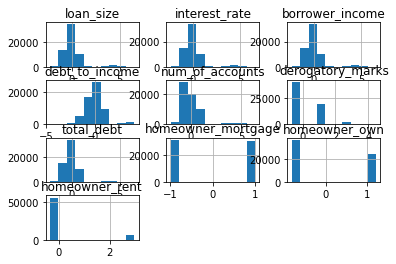

In [93]:
# convert the array back to a dataframe
dataset = pd.DataFrame(X_train_s)
dataset.columns=X_train.columns
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()


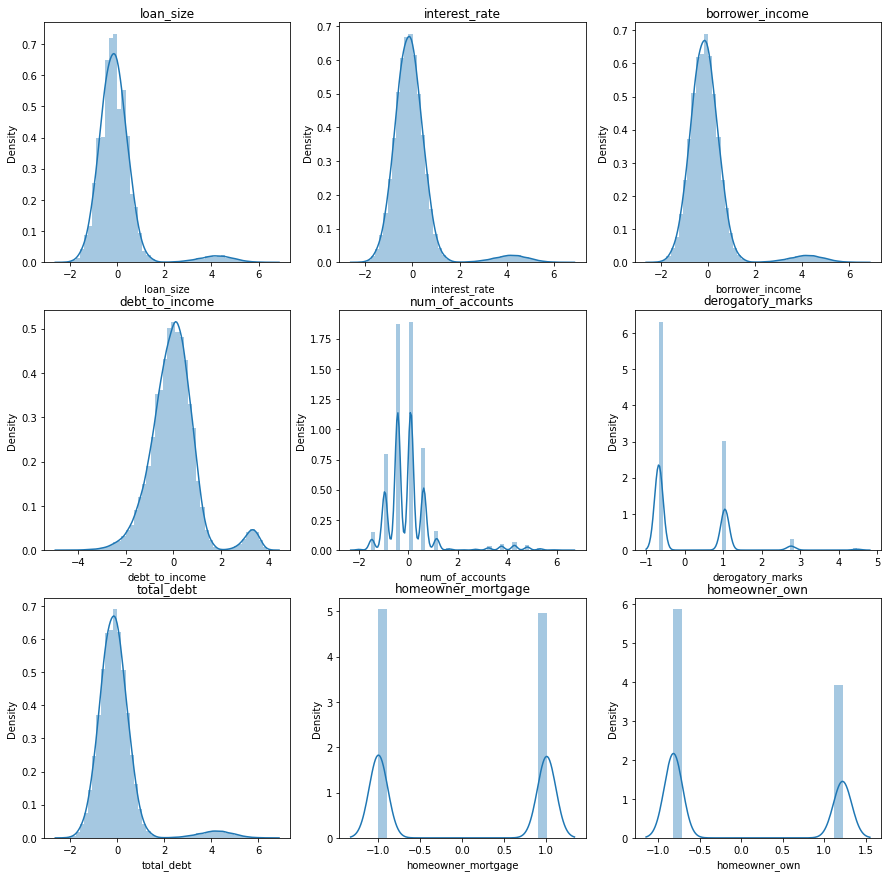

In [94]:
#Check distribution
fig, axes = plt.subplots(nrows = 3, ncols = 3)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 15)

for ax, col in zip(axes, dataset.columns):
  sns.distplot(dataset[col], ax = ax)
  ax.set_title(col)

# Simple Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs', random_state=1)
log_reg.fit(X_train_s, y_train)

LogisticRegression(random_state=1)

In [96]:
#Check for underfitting
log_reg.score(X_train, y_train)

0.9677564970658412

In [97]:
# Calculated the balanced accuracy score
# Since we are interested in the ouctome of both the possibilities (low_risk and high_risk) we will use this score.
# Balanced Accuracy = (Sensitivity + Specificity) / 2 

y_pred = log_reg.predict(X_test_s)
balanced_accuracy_score(y_test, y_pred)

0.9895346481876333

In [98]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test, y_pred)

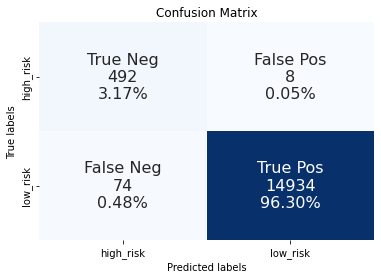

In [99]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
categories = ['high_risk', 'low_risk']
sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 16},fmt='', cmap='Blues', cbar=False,xticklabels=categories,yticklabels=categories,ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [100]:
# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, y_pred,target_names=categories
                                   ))


                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.87      0.98      1.00      0.92      0.99      0.98       500
   low_risk       1.00      1.00      0.98      1.00      0.99      0.98     15008

avg / total       1.00      0.99      0.98      0.99      0.99      0.98     15508



In [101]:
Dict_Balanced['LogisticRegression'] = balanced_accuracy_score(y_test, y_pred)*10000

Dict_gm['LogisticRegression'] = geometric_mean_score(y_test, y_pred)*10000
Dict_r['LogisticRegression'] = recall_score(y_test, y_pred)*10000


In [102]:
#Cross-validation is a technique used to protect against overfitting in a predictive model, particularly in a 
#case where the amount of data may be limited. In cross-validation, you make a fixed number of folds (or partitions)
#of the data, run the analysis on each fold, and then average the overall error estimate.
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# Stratified k-Fold is a variation of the standard k-Fold CV technique which is designed to be effective in such cases 
#of target imbalance. 
# 

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(log_reg, X, y, cv=cv,scoring='balanced_accuracy')
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.93566791 0.94753465 0.9658678  0.95333475 0.94106823 0.95153465
 0.95146768 0.94173424 0.95746768 0.9470012  0.95726812 0.94120149
 0.95353465 0.94960128 0.9478678  0.96546802 0.94580088 0.94926776
 0.94560096 0.9410012  0.9530016  0.95120149 0.94580117 0.93360128
 0.95826866 0.94353465 0.95753432 0.9556676  0.96013408 0.93006744]


# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [103]:
# Resample the training data with the RandomOversampler
#RandomOverSampler duplicates rows of the minority class.
#Resample will be done only on training data set. 
log_reg_ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = log_reg_ros.fit_resample(X_train_s, y_train)


# 1 = low_risk and 0 = high_risk
# View the count of target classes with Counter
Counter(y_resampled)

Counter({1: 60028, 0: 60028})

In [104]:
# convert the array back to a dataframe
resampled_df = pd.DataFrame(X_resampled)
resampled_df.columns=X_train.columns
# summarize
print(resampled_df.describe())


           loan_size  interest_rate  borrower_income  debt_to_income  \
count  120056.000000  120056.000000    120056.000000   120056.000000   
mean        2.008436       2.008544         2.008526        1.559945   
std         2.264778       2.264888         2.264860        1.787273   
min        -2.295706      -2.295965        -2.295996       -4.629641   
25%        -0.147148      -0.164542        -0.159055       -0.045888   
50%         2.001411       1.993846         1.989825        2.052455   
75%         4.197715       4.192684         4.198396        3.276419   
max         6.537256       6.553316         6.550225        4.101503   

       num_of_accounts  derogatory_marks     total_debt  homeowner_mortgage  \
count    120056.000000     120056.000000  120056.000000       120056.000000   
mean          1.984793          1.465231       2.008526           -0.007340   
std           2.243971          1.753612       2.264860            0.999920   
min          -2.009535         -0.6

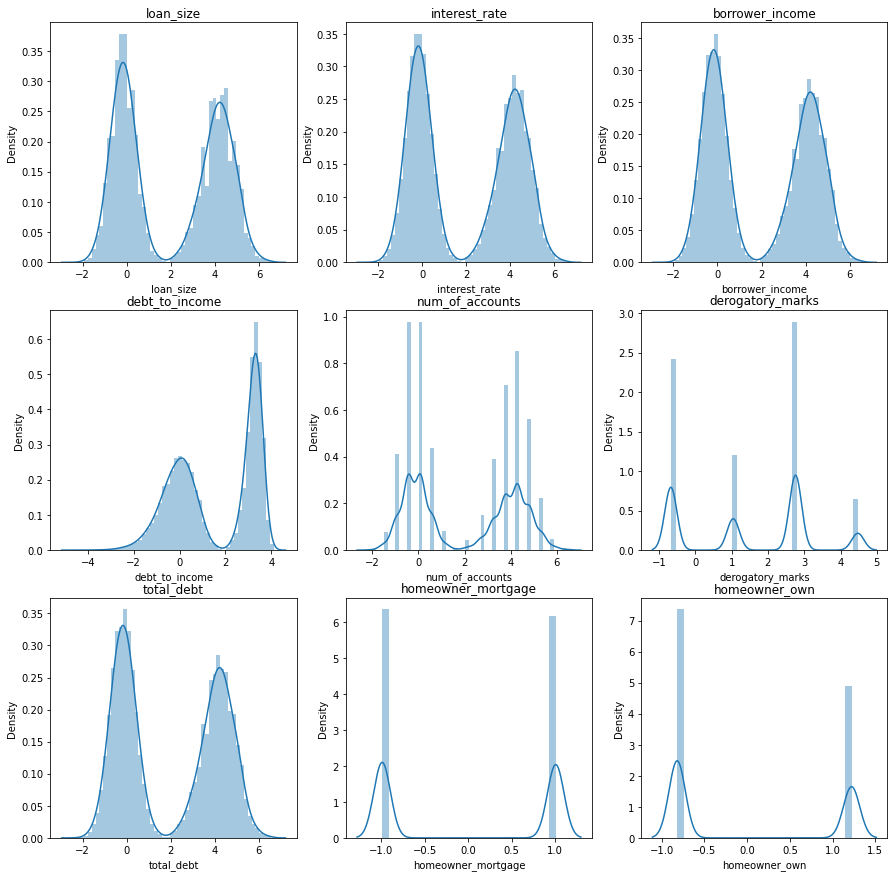

In [105]:
#Check distribution
fig, axes = plt.subplots(nrows = 3, ncols = 3)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 15)

for ax, col in zip(axes, resampled_df.columns):
  sns.distplot(resampled_df[col], ax = ax)
  ax.set_title(col)

In [106]:
# Train the Logistic Regression model using the resampled data
log_reg_s = LogisticRegression(solver='lbfgs', random_state=1)
log_reg_s.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [107]:
# Calculated the balanced accuracy score
y_pred_sampled = log_reg_s.predict(X_test_s)
balanced_accuracy_score(y_test, y_pred_sampled)

0.9943014392324094

In [108]:
# Display the confusion matrix
cf_matrix_sampled=confusion_matrix(y_test, y_pred_sampled)

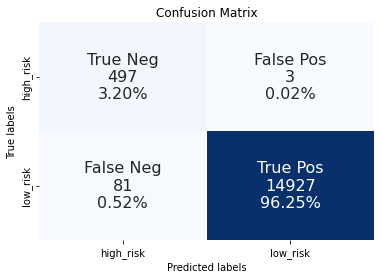

In [109]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_sampled.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_sampled.flatten()/np.sum(cf_matrix_sampled)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
categories = ['high_risk', 'low_risk']
sns.heatmap(cf_matrix_sampled, annot=labels, annot_kws={"size": 16},fmt='', cmap='Blues', cbar=False,xticklabels=categories,yticklabels=categories,ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [110]:
# Print the imbalanced classification report
# 1 = low_risk and 0 = high_risk
print(classification_report_imbalanced(y_test, y_pred_sampled))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.99      0.99      0.92      0.99      0.99       500
          1       1.00      0.99      0.99      1.00      0.99      0.99     15008

avg / total       1.00      0.99      0.99      0.99      0.99      0.99     15508



In [111]:
Dict_Balanced['LR_ROS'] = balanced_accuracy_score(y_test, y_pred_sampled)*10000


Dict_gm['LR_ROS'] = geometric_mean_score(y_test, y_pred_sampled)*10000
Dict_r['LR_ROS'] = recall_score(y_test, y_pred_sampled)*10000

### SMOTE Oversampling

In [112]:
# Resample the training data with SMOTE
#SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in
#the feature space and drawing a new sample at a point along that line.

smote = SMOTE(random_state=1, sampling_strategy=1.0)
X_smote, y_smote = smote.fit_resample(X_train_s, y_train)

# 1 = low_risk and 0 = high_risk
# View the count of target classes with Counter
Counter(y_smote)

Counter({1: 60028, 0: 60028})

In [113]:
# Train the Logistic Regression model using the resampled data
log_reg_smote = LogisticRegression(solver='lbfgs', random_state=1)
log_reg_smote.fit(X_smote, y_smote)

LogisticRegression(random_state=1)

In [114]:
# Calculated the balanced accuracy score
y_pred_smote = log_reg_s.predict(X_test_s)
balanced_accuracy_score(y_test, y_pred_smote)

0.9943014392324094

In [115]:
# Display the confusion matrix
# 1 = low_risk and 0 = high_risk
print(confusion_matrix(y_test, y_pred_smote))

[[  497     3]
 [   81 14927]]


In [116]:
# Print the imbalanced classification report
# 1 = low_risk and 0 = high_risk
print(classification_report_imbalanced(y_test, y_pred_smote))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.99      0.99      0.92      0.99      0.99       500
          1       1.00      0.99      0.99      1.00      0.99      0.99     15008

avg / total       1.00      0.99      0.99      0.99      0.99      0.99     15508



In [117]:
Dict_Balanced['LR_SMOTE'] = balanced_accuracy_score(y_test, y_pred_smote)*10000


Dict_gm['LR_SMOTE'] = geometric_mean_score(y_test, y_pred_smote)*10000
Dict_r['LR_SMOTE'] = recall_score(y_test, y_pred_smote)*10000

# Undersampling

In this section, you will test an undersampling algorithm to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [118]:
# Resample the data using the ClusterCentroids resampler
#This technique makes undersampling by generating a new set based on centroids by clustering methods. 
#The algorithm is generating a new set according to the cluster centroid of a KMeans algorithm
cc_u = ClusterCentroids(random_state=1,sampling_strategy="auto")
X_cc, y_cc = cc_u.fit_resample(X_train_s, y_train)

# 1 = low_risk and 0 = high_risk
# View the count of target classes with Counter
Counter(y_cc)

Counter({0: 2000, 1: 2000})

In [119]:
# Train the Logistic Regression model using the resampled data
log_reg_cc = LogisticRegression(solver='lbfgs', random_state=1)
log_reg_cc.fit(X_cc, y_cc)

LogisticRegression(random_state=1)

In [120]:
# Calculate the balanced accuracy score
y_pred_cc = log_reg_cc.predict(X_test_s)
balanced_accuracy_score(y_test, y_pred_cc)

0.9925013326226013

In [121]:
# Display the confusion matrix
# 1 = low_risk and 0 = high_risk
print(confusion_matrix(y_test, y_pred_cc))

[[  495     5]
 [   75 14933]]


In [122]:
# Print the imbalanced classification report
# 1 = low_risk and 0 = high_risk
print(classification_report_imbalanced(y_test, y_pred_cc))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.99      1.00      0.93      0.99      0.98       500
          1       1.00      1.00      0.99      1.00      0.99      0.99     15008

avg / total       1.00      0.99      0.99      1.00      0.99      0.99     15508



In [123]:
Dict_Balanced['LR_CC'] = balanced_accuracy_score(y_test, y_pred_cc)*10000


Dict_gm['LR_CC'] = geometric_mean_score(y_test, y_pred_cc)*10000
Dict_r['LR_CC'] = recall_score(y_test, y_pred_cc)*10000

# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [124]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN

sm = SMOTEENN(random_state=1)
X_sm, y_sm = sm.fit_resample(X_train_s, y_train)

# 1 = low_risk and 0 = high_risk
# View the count of target classes with Counter
Counter(y_sm)

Counter({0: 59084, 1: 59580})

In [125]:
# Train the Logistic Regression model using the resampled data
log_reg_snn = LogisticRegression(solver='lbfgs', random_state=1)
log_reg_snn.fit(X_sm, y_sm)

LogisticRegression(random_state=1)

In [126]:
# Calculate the balanced accuracy score
y_pred_snn = log_reg_snn.predict(X_test_s)
# 1 = low_risk and 0 = high_risk
balanced_accuracy_score(y_test, y_pred_snn)

0.9943347547974414

In [127]:
# Display the confusion matrix
# 1 = low_risk and 0 = high_risk
print(confusion_matrix(y_test, y_pred_snn))

[[  497     3]
 [   80 14928]]


In [128]:
# Print the imbalanced classification report
# 1 = low_risk and 0 = high_risk
print(classification_report_imbalanced(y_test, y_pred_snn))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.99      0.99      0.92      0.99      0.99       500
          1       1.00      0.99      0.99      1.00      0.99      0.99     15008

avg / total       1.00      0.99      0.99      0.99      0.99      0.99     15508



In [129]:
Dict_Balanced['LR_SMOTEENN'] = balanced_accuracy_score(y_test, y_pred_snn)*10000


Dict_gm['LR_SMOTEENN'] = geometric_mean_score(y_test, y_pred_snn)*10000
Dict_r['LR_SMOTEENN'] = recall_score(y_test, y_pred_snn)*10000

# Final Questions

1. Which model had the best balanced accuracy score?

   YOUR ANSWER HERE.

2. Which model had the best recall score?

    YOUR ANSWER HERE.

3. Which model had the best geometric mean score?

    YOUR ANSWER HERE.


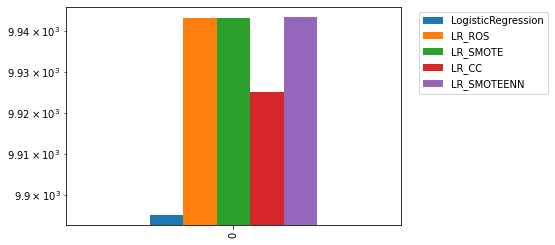

In [130]:
#Which model had the best balanced accuracy score?
# Too close to call but SMOTEENN is the best.

df_balanced = pd.DataFrame([Dict_Balanced], columns=Dict_Balanced.keys())
#df.hvplot(kind='bar',rot=45,height=500)
df_balanced.plot.bar()
plt.yscale("log",base=10)
#plt.ylim(ymax = 100, ymin = 90)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [131]:
df_balanced

LogisticRegression       LR_ROS     LR_SMOTE        LR_CC  LR_SMOTEENN
0         9895.346482  9943.014392  9943.014392  9925.013326  9943.347548

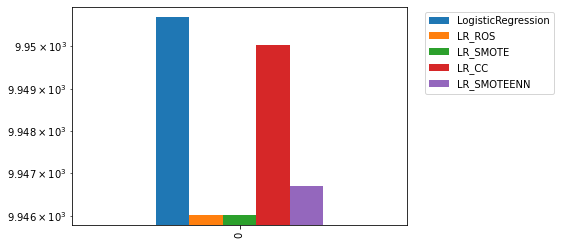

In [139]:
#Which model had the best recall score?
# Too close to call but LogisticRegression is the best.
df_recall = pd.DataFrame([Dict_r], columns=Dict_r.keys())
#df.hvplot(kind='bar',rot=45,height=500)
df_recall.plot.bar()
plt.yscale("log",base=10)
#plt.ylim(ymax = 100, ymin = 90)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [138]:
df_recall

LogisticRegression       LR_ROS     LR_SMOTE        LR_CC  LR_SMOTEENN
0         9950.692964  9946.028785  9946.028785  9950.026652  9946.695096

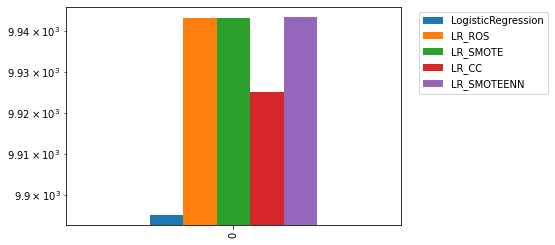

In [136]:
#Which model had the best geometric score?
# Too close to call but SMOTEENN is the best.
df_gm = pd.DataFrame([Dict_gm], columns=Dict_gm.keys())
#df.hvplot(kind='bar',rot=45,height=500)
df_gm.plot.bar()
plt.yscale("log",base=10)
#plt.ylim(ymax = 100, ymin = 90)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [137]:
df_gm

LogisticRegression       LR_ROS     LR_SMOTE        LR_CC  LR_SMOTEENN
0         9895.191699  9943.013935  9943.013935  9924.981806  9943.346984